## Importing libraries

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import layers, models, optimizers
from PIL import Image, ImageOps

## Reading data

In [2]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    c = 0
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    image_files.sort()  # opcjonalnie

    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj i przeskaluj obraz do dokładnego rozmiaru target_size (bez paddingu)
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize(target_size, Image.LANCZOS)

        # Konwersja do numpy + preprocess_input (dla MobileNet)
        img_array = np.array(img_resized, dtype=np.float32)
        img_array = preprocess_input(img_array)

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)
        # if c == 1:
        #     plt.imshow(img_resized)
        #     print(img_path)
        #     print(count)
        #     break
        # c += 1

    return np.array(X), np.array(y)

## Getting the training set and the test set

In [3]:
X_train, y_train = load_dataset('ShanghaiTech/part_B/train_data/images/', 'ShanghaiTech/part_B/train_data/ground-truth/')

In [4]:
X_test, y_test = load_dataset('ShanghaiTech/part_B/test_data/images/', 'ShanghaiTech/part_B/test_data/ground-truth/')

## Building the model

In [9]:
# Load pre-trained model without top classifier layers
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

base_model.trainable = True
for layer in base_model.layers[:-30]: # Unfreeze last 30 layers
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

## Data augmentation and training the model

In [10]:
# Function to augment
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x), y

training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_set = training_set.map(augment)  # augment
training_set = training_set.batch(32).prefetch(tf.data.AUTOTUNE)
history = model.fit(training_set, batch_size=32,
    epochs=20, shuffle=True, validation_data=(X_test, y_test)
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 164s 10s/step - loss: 22851.6406 - mae: 118.3165 - val_loss: 11024.4600 - val_mae: 66.3847
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 116s 9s/step - loss: 9749.2461 - mae: 72.1263 - val_loss: 6084.3110 - val_mae: 58.7039
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 115s 9s/step - loss: 5846.8135 - mae: 57.2280 - val_loss: 6351.0591 - val_mae: 48.0581
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 114s 9s/step - loss: 5051.7075 - mae: 46.6966 - val_loss: 5346.0420 - val_mae: 43.3792
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 114s 9s/step - loss: 3141.7036 - mae: 39.6409 - val_loss: 4998.8862 - val_mae: 42.3989
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 114s 9s/step - loss: 3140.1157 - mae: 37.1212 - val_loss: 4733.9492 - val_mae: 41.3703
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 114s 9s/step - loss: 3539.5212 - mae: 40.1761 - val_loss: 4481.0239 - val_mae: 40.4550
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 114s 9s/step - loss: 3044.8489 - mae: 37.2987 - val_loss: 4974.4946 - val_mae: 43.9

## Training curves visualisation

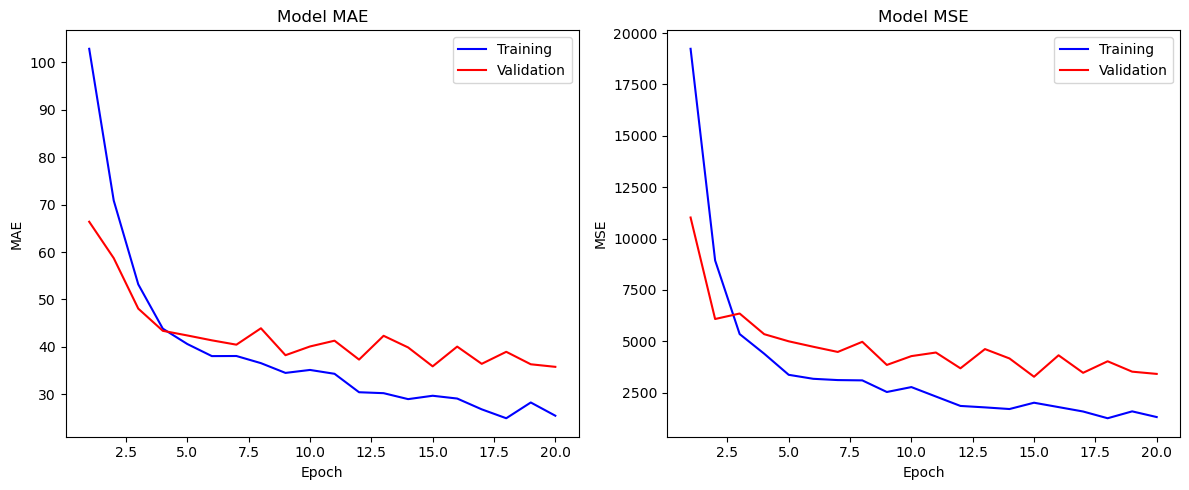

In [11]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(mae) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

## Making predictions

In [12]:
y_pred = np.round(model.predict(X_test))

10/10 ━━━━━━━━━━━━━━━━━━━━ 61s 5s/step  


In [13]:
y_pred.reshape(len(y_pred), 1)
y_test.reshape(len(y_test), 1)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[ 26.  23.]
 [158. 181.]
 [113. 157.]
 [ 56.  37.]
 [ 76.  70.]
 [ 43.  57.]
 [ 48.  44.]
 [222. 227.]
 [209. 165.]
 [278. 476.]
 [134. 139.]
 [234. 316.]
 [137. 164.]
 [136. 110.]
 [ 44.  20.]
 [158. 131.]
 [ 67.  48.]
 [184. 183.]
 [143. 101.]
 [226. 204.]
 [ 83.  40.]
 [ 95. 143.]
 [111. 146.]
 [307. 513.]
 [ 67.  70.]
 [104. 175.]
 [ 66.  51.]
 [ 84.  55.]
 [ 32.  67.]
 [ 64.  72.]
 [ 53.  56.]
 [114. 165.]
 [ 24.  32.]
 [112. 149.]
 [ 68.  48.]
 [106.  80.]
 [ 76. 117.]
 [ 97. 162.]
 [175. 137.]
 [179. 120.]
 [ 57.  72.]
 [104. 122.]
 [112. 198.]
 [ 86. 133.]
 [ 97. 147.]
 [ 11.  29.]
 [ 27.  70.]
 [ 24.  35.]
 [ 79.  24.]
 [197. 251.]
 [ 67.  59.]
 [ 56.  67.]
 [ 49.  61.]
 [171. 248.]
 [175. 252.]
 [156. 147.]
 [ 29.  57.]
 [105. 121.]
 [ 35.  47.]
 [311. 505.]
 [165. 297.]
 [218. 465.]
 [104. 167.]
 [ 46.  43.]
 [ 35.  46.]
 [ 90.  91.]
 [175. 263.]
 [105.  92.]
 [107. 117.]
 [ 54.  48.]
 [ 67.  54.]
 [ 90.  73.]
 [ 68. 122.]
 [ 57.  60.]
 [233. 170.]
 [ 93. 167.]
 [ 46.  57.]

## Metrics

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
print("R2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R2: 0.6226413249969482
MSE: 3415.15185546875
MAE: 35.78480911254883
RMSE: 58.439300537109375
